
This script was used to perform grid search for 1 s - intra-session RMS.

________________________________________________________________________________
Model consists of 4 fully-connected layers and one drop-out layer.<br>
Adam optimizer with initial learning rate=0.01 and exponential decay is used. Learning rate=0.1, 0.001 and step decay are also tested, but as they seemed to perform worse, they are excluded from GS.<br>
__________________________________________
Number of nodes in all the layers, activation function and drop rate are grid search parameters: <br>

p = {'activation':['relu', 'elu'],<br>
     'lr': [0.01],,<br>
     '1_hidden_layer': [ 32, 40, 64],<br>
     '2_hidden_layer': [ 40, 64, 80, 128, 256], <br>
     '3_hidden_layer': [ 64, 80, 128, 256],<br>
     '4_hidden_layer': [ 64, 80, 128, 256], <br>
     'drop_rate': [ 0, 0.05, 0.1, 0.15, 0.2], <br>
     'epochs': [100]} 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.1

In [ ]:
!pip install git+https://github.com/autonomio/talos@1.0

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Embedding
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math

reduced = False - corresponds to 1 s RMS.

In [ ]:
session=2
reduced=False
if session: 
  if reduced:
    folder='/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_200ms_s'+str(session)
  else:
    folder='/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_1s_s'+str(session)
    
  paths=[folder+'_train.csv',folder+'_valid.csv',folder+'_test.csv']
else:
  folder='/content/drive/Shared drives/Nikolina/RMS data/'
  paths=[folder+'train.csv',folder+'rms_session4.csv',folder+'rms_session5.csv']

print(paths)

save_path='/content/drive/Shared drives/Nikolina/29.5. Results/'

grid_search_res='drive/Shared drives/Nikolina/Results/RMS - intra-session - 1s/Session'+str(session)

['/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_1s_s2_train.csv', '/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_1s_s2_valid.csv', '/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_1s_s2_test.csv']


Read the data.

In [ ]:
e=65
#ch=[4,5,7,17,20,21,23,25,27,28,29,32,33,51]
ch=np.arange(0,56,1)
df = pd.read_csv(paths[0])
in_train=df.values[ch,:].T
out_train=df.values[56:e,:].T

#valid
df = pd.read_csv(paths[1])
in_valid=df.values[ch,:].T
out_valid=df.values[56:e,:].T

#test
df = pd.read_csv(paths[2])
in_test=df.values[ch,:].T
out_test=df.values[56:e,:].T

print('train data: ', np.shape(in_train),np.shape(out_train))
print('validation data: ', np.shape(in_valid),np.shape(out_valid))
print('test data: ', np.shape(in_test),np.shape(out_test))

train data:  (2064, 56) (2064, 9)
validation data:  (688, 56) (688, 9)
test data:  (688, 56) (688, 9)


Define the model, lr scheduler and function for plotting the best resuls.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


def evaluation(prediction, desired_out, title=None, save=False, path=None,limit=None):
  """For a given predicted labels and ground truth, plots both of them.
  If set is large, use limit  (vector of two indeices) - boundaries to plot subset of the set. 
  f save, define also path as a folder and filename."""
  predicted_class=[]
  gt=[]

  for sample in range(np.shape(prediction)[0]):
    predicted_class.append(np.argmax(prediction[sample,:]))
    gt.append(np.argmax(desired_out[sample,:]))

  plt.figure(figsize=(20,10))
  if limit:
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(predicted_class[limit[0]:limit[1]])+1,color='#E2A76F',linewidths=9)
    plt.scatter(np.arange(0,limit[1]-limit[0],1),np.array(gt[limit[0]:limit[1]])+1,color='#26292c',marker='*',linewidths=5)
  else:
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(predicted_class)+1,color='#355C7D',linewidths=9)
    plt.scatter(np.arange(0,np.shape(prediction)[0],1),np.array(gt)+1,color='#FFA500',marker='*',linewidths=4)

  plt.xlabel('sample',fontsize=20)
  plt.ylabel('class',fontsize=20)
  if title:
    plt.title(title)
  #plt.legend(('predicted class','ground truth'),prop={'size': 27},loc=1)

  if save:
    plt.savefig(path)
  plt.show()


def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
"""
def step_decay(epoch,lrate):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
"""

def create_mlp(X_train, y_train, X_val, y_val,params):
  dim=56
  model = Sequential()

  # first FC layer
  model.add(Dense(params['1_hidden_layer'], input_dim=dim, activation=params['activation']))

  # second FC
  model.add(Dense(params['2_hidden_layer'], 
                    activation=params['activation']))

  # third FC
  model.add(Dense(params['3_hidden_layer'], 
                    activation=params['activation']))

  # fourth FC
  model.add(Dense(params['4_hidden_layer'], 
                    activation=params['activation']))
  model.add(Dropout(params['drop_rate']))

  # output
  model.add(Dense(9, activation="softmax"))

  # optimizer - Adam
  optim = keras.optimizers.Adam(learning_rate=params['lr'], beta_1=0.9, beta_2=0.99, epsilon=1e-7)
  model.compile(optimizer=optim, 
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  # define callbacks
  lrate_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
  early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  callbacks_list = [early_stopper,lrate_schedule]

  # fit
  history = model.fit(X_train, 
                  y_train,
                  epochs=params['epochs'],
                  verbose=0,
                  validation_data=[X_val, y_val],
                  callbacks=callbacks_list,
                  batch_size=64)
  

  return history, model

In [ ]:
p = {'activation':['relu', 'elu'],
     'lr': [0.01],# "RMSprop"],
     '1_hidden_layer': [ 32, 40, 64],
     '2_hidden_layer': [ 40, 64, 80, 128, 256],
     '3_hidden_layer': [ 64, 80, 128, 256],
     '4_hidden_layer': [ 64, 80, 128, 256],
     'drop_rate': [ 0, 0.05, 0.1, 0.15, 0.2],
     'epochs': [100]}

In [ ]:
from talos import Scan

h = Scan(in_train, 
         out_train, 
         model=create_mlp, 
         params=p,
         x_val=in_valid,
         y_val=out_valid,
         experiment_name = grid_search_res)

Find a best model, test and plot.

In [ ]:
path='/content/drive/Shared drives/Nikolina/Results/RMS - intra-session - 1s/session'+str(session)+'.csv'
results=pd.read_csv(path) 

In [ ]:
val_acc=results.val_accuracy
print(max(val_acc))
best=np.where(val_acc==max(val_acc))[0]
print(best)
print(val_acc[best])

0.888081372
[1762]
1762    0.888081
Name: val_accuracy, dtype: float64


In [ ]:
p = {'activation':'elu',
     'lr': 0.01,
     '1_hidden_layer': 64 ,
     '2_hidden_layer': 256,
     '3_hidden_layer': 128,
     '4_hidden_layer': 80 ,
     'drop_rate': 0.1,
     'epochs': 100}

In [ ]:
predictions=[]
test_acc=[]
valid_acc=[]
train_acc=[]

for i in range(100):
  print('\nTraining, iteration '+ str(i))
  h,model=create_mlp(in_train, out_train, in_valid, out_valid,p)
  prediction = model.predict(in_test)
  test_scores = model.evaluate(in_test, out_test, verbose = 0, batch_size=64)
  
  print('Train accuracy:' , h.history['accuracy'][-1])
  print('Test accuracy:',test_scores[-1])
  print('Validation accuracy:',h.history['val_accuracy'][-1])

  predictions.append(prediction)

  test_acc.append(test_scores[-1])
  train_acc.append( h.history['accuracy'][-1])
  valid_acc.append(h.history['val_accuracy'][-1])


Training, iteration 0
Train accuracy: 1.0
Test accuracy: 0.8139534592628479
Validation accuracy: 0.8706395626068115

Training, iteration 1
Train accuracy: 0.99951553
Test accuracy: 0.867732584476471
Validation accuracy: 0.8590116500854492

Training, iteration 2
Train accuracy: 1.0
Test accuracy: 0.8154069781303406
Validation accuracy: 0.8691860437393188

Training, iteration 3
Train accuracy: 0.99951553
Test accuracy: 0.8241279125213623
Validation accuracy: 0.867732584476471

Training, iteration 4
Train accuracy: 1.0
Test accuracy: 0.8212209343910217
Validation accuracy: 0.875

Training, iteration 5
Train accuracy: 1.0
Test accuracy: 0.8037790656089783
Validation accuracy: 0.8517441749572754

Training, iteration 6
Train accuracy: 1.0
Test accuracy: 0.8648256063461304
Validation accuracy: 0.875

Training, iteration 7
Train accuracy: 1.0
Test accuracy: 0.8270348906517029
Validation accuracy: 0.8633720874786377

Training, iteration 8
Train accuracy: 1.0
Test accuracy: 0.8343023061752319
V

In [ ]:
print('train accuracy: '+ str(np.mean(train_acc)) + '+-' + str(np.std(train_acc)))
print('validation accuracy: '+ str(np.mean(valid_acc)) + '+-' + str(np.std(valid_acc)))
print('test accuracy: '+ str(np.mean(test_acc)) + '+-' + str(np.std(test_acc)))

train accuracy: 0.99979174+-0.0003443257
validation accuracy: 0.8679941922426224+-0.008839739367773672
test accuracy: 0.8327470898628235+-0.019035989737977724


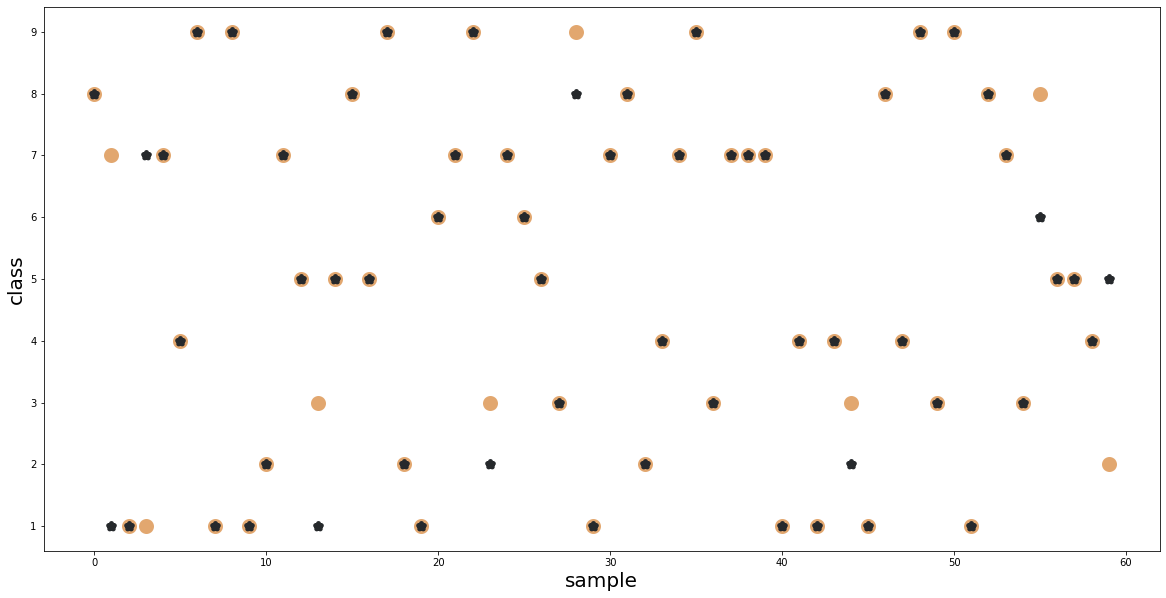

In [ ]:
pp='/content/drive/Shared drives/Nikolina/Results/Report figures/session'+str(session)+'RMS1s.png'
evaluation(prediction, out_test, title=None, save=True, path=pp,limit=[350,410])